In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

import acquire, prepare, wrangle_zillow, features, model

## Scale train/validate/test by standardscaler

In [2]:
# Load train/validate/test datasets labled with at least cluster1-2 from csv

train = pd.read_csv('train.csv', index_col=0)
validate = pd.read_csv('validate.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

In [3]:
# Check the shape of the 3 datasets

train.shape, validate.shape, test.shape

((31028, 24), (13299, 22), (7823, 22))

In [4]:
# Create masks for group 1 in cluster1 and group 0 in cluster2. 

# mask for train dataset
mask_tr_cluster1_1 = (train.cluster1 == 1)
mask_tr_cluster2_0 = (train.cluster2 == 0)

# mask for validate dataset
mask_v_cluster1_1 = (validate.cluster1 == 1)
mask_v_cluster2_0 = (validate.cluster2 == 0)

# mask for test dataset
mask_t_cluster1_1 = (test.cluster1 == 1)
mask_t_cluster2_0 = (test.cluster2 == 0)

# Create train/validate/test for group 1 in cluster1

train_cluster1_1 = train[mask_tr_cluster1_1]
validate_cluster1_1 = validate[mask_v_cluster1_1]
test_cluster1_1 = test[mask_t_cluster1_1]

# Create train/validate/test for group 0 in cluster2

train_cluster2_0 = train[mask_tr_cluster2_0]
validate_cluster2_0 = validate[mask_v_cluster2_0]
test_cluster2_0 = test[mask_t_cluster2_0]

train_cluster1_1.shape, train_cluster2_0.shape

((15165, 24), (26841, 24))

In [5]:
# Identify numeric columns needs to be scaled

train.columns

Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt',
       'latitude', 'longitude', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'error_type',
       'fips_Orange', 'fips_Ventura', 'logtaxvaluedollarcnt', 'cluster1',
       'cluster2', 'cluster3', 'cluster4'],
      dtype='object')

In [6]:
# Create a variable to hold the numeric features be scaled, 16 in total. 

columns_to_scale = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
                    'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt',
                    'latitude', 'longitude', 'lotsizesquarefeet',
                    'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
                    'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount',
                    'logtaxvaluedollarcnt']

len(columns_to_scale)

16

In [7]:
# Scale train/validate/test for group 1 in cluster1

scaler, train_scaled_1_1, validate_scaled_1_1, test_scaled_1_1 = prepare.scale_standard(train_cluster1_1,
                                                                                        validate_cluster1_1,
                                                                                        test_cluster1_1,
                                                                                        columns_to_scale)
train_scaled_1_1.shape, validate_scaled_1_1.shape, test_scaled_1_1.shape

((15165, 24), (6386, 22), (3765, 22))

In [10]:
# Summarize train_scaled_1_1 by .info()

train_scaled_1_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15165 entries, 17052781 to 14530930
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   logerror                             15165 non-null  float64
 1   error_type                           15165 non-null  int64  
 2   fips_Orange                          15165 non-null  int64  
 3   fips_Ventura                         15165 non-null  int64  
 4   cluster1                             15165 non-null  int64  
 5   cluster2                             15165 non-null  int64  
 6   cluster3                             15165 non-null  int64  
 7   cluster4                             15165 non-null  int64  
 8   bathroomcnt_scaled                   15165 non-null  float64
 9   bedroomcnt_scaled                    15165 non-null  float64
 10  buildingqualitytypeid_scaled         15165 non-null  float64
 11  calculatedfinished

((15165, 24), None)

In [11]:
# Scale train/validate/test for group 2 in cluster0

scaler, train_scaled_2_0, validate_scaled_2_0, test_scaled_2_0 = prepare.scale_standard(train_cluster2_0,
                                                                                        validate_cluster2_0,
                                                                                        test_cluster2_0,
                                                                                        columns_to_scale)
scaler, train_scaled_2_0.shape, validate_scaled_2_0.shape, test_scaled_2_0.shape

(StandardScaler(copy=True, with_mean=True, with_std=True),
 (26841, 24),
 (11496, 22),
 (6798, 22))

In [12]:
# Summarize train_scaled_2_0 by .info()

train_scaled_2_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26841 entries, 17052781 to 14530930
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   logerror                             26841 non-null  float64
 1   error_type                           26841 non-null  int64  
 2   fips_Orange                          26841 non-null  int64  
 3   fips_Ventura                         26841 non-null  int64  
 4   cluster1                             26841 non-null  int64  
 5   cluster2                             26841 non-null  int64  
 6   cluster3                             26841 non-null  int64  
 7   cluster4                             26841 non-null  int64  
 8   bathroomcnt_scaled                   26841 non-null  float64
 9   bedroomcnt_scaled                    26841 non-null  float64
 10  buildingqualitytypeid_scaled         26841 non-null  float64
 11  calculatedfinished

## Feature Engineering on training dataset

In [16]:
# Show all the columns in training dataset, 19 in total

predictors=['error_type', 'fips_Orange', 'fips_Ventura',
            'bathroomcnt_scaled', 'bedroomcnt_scaled', 'buildingqualitytypeid_scaled',
            'calculatedfinishedsquarefeet_scaled', 'finishedsquarefeet12_scaled',
            'fullbathcnt_scaled', 'latitude_scaled', 'longitude_scaled',
            'lotsizesquarefeet_scaled', 'roomcnt_scaled', 'yearbuilt_scaled',
            'structuretaxvaluedollarcnt_scaled', 'taxvaluedollarcnt_scaled',
            'landtaxvaluedollarcnt_scaled', 'taxamount_scaled','logtaxvaluedollarcnt_scaled']

In [33]:
train_scaled_1_1.head()

,logerror,error_type,fips_Orange,fips_Ventura,cluster1,cluster2,cluster3,cluster4,bathroomcnt_scaled,bedroomcnt_scaled,...,latitude_scaled,longitude_scaled,lotsizesquarefeet_scaled,roomcnt_scaled,yearbuilt_scaled,structuretaxvaluedollarcnt_scaled,taxvaluedollarcnt_scaled,landtaxvaluedollarcnt_scaled,taxamount_scaled,logtaxvaluedollarcnt_scaled
parcelid,,,,,,,,,,,,,,,,,,,,,
17052781,0.045179,1,0,1,1,0,0,2,-0.133983,-0.236717,...,1.500195,-2.948718,-0.032643,1.290202,-0.545964,0.298036,0.648764,0.478141,0.484278,0.719477
11162056,0.000996,1,0,0,1,0,0,0,1.201886,0.937961,...,1.451369,-0.497984,-0.043036,-0.649257,1.617841,2.274282,0.316700,-1.159848,1.098956,0.445165
14033552,-0.012577,0,1,0,1,0,4,2,1.201886,2.112640,...,-1.170089,0.742929,-0.039218,2.259931,0.374804,0.274740,0.147617,-0.026855,-0.081082,0.295356
14253441,-0.065676,0,1,0,1,0,4,2,-0.133983,-0.236717,...,-1.051450,0.997035,-0.067096,1.290202,0.604996,-0.425464,-1.053754,-0.815781,-1.066902,-1.056418
14142789,0.010418,1,1,0,1,0,4,2,1.869821,0.937961,...,-0.557345,0.659954,-0.027959,1.613445,0.052535,0.527611,1.042448,0.736589,0.606999,1.015539


In [34]:
# Set the X and y for group 1 in cluster1

X_train_scaled_1_1 = train_scaled_1_1[predictors]
y_train_1_1 = train_scaled_1_1['logerror']

X_validate_scaled_1_1 = validate_scaled_1_1[predictors]
y_validate_1_1 = validate_scaled_1_1['logerror']

X_test_scaled_1_1 = test_scaled_1_1[predictors]
y_test_1_1 = test_scaled_1_1['logerror']

X_train_scaled_1_1.shape, X_validate_scaled_1_1.shape, X_test_scaled_1_1.shape

((15165, 19), (6386, 19), (3765, 19))

In [35]:
# Set the X and y for group 2 in cluster0

X_train_scaled_2_0 = train_scaled_2_0[predictors]
y_train_2_0 = train_scaled_2_0['logerror']

X_validate_scaled_2_0 = validate_scaled_2_0[predictors]
y_validate_2_0 = validate_scaled_2_0['logerror']

X_test_scaled_2_0 = test_scaled_2_0[predictors]
y_test_2_0 = test_scaled_2_0['logerror']

X_train_scaled_2_0.shape, X_validate_scaled_2_0.shape, X_test_scaled_2_0.shape

((26841, 19), (11496, 19), (6798, 19))

### Select top 10 features by select KBest

In [36]:
# Group 1 in cluster1

f_features_1_1 = features.select_kbest(X_train_scaled_1_1, y_train_1_1, 10)
f_features_1_1

['error_type',
 'fips_Orange',
 'bathroomcnt_scaled',
 'bedroomcnt_scaled',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'fullbathcnt_scaled',
 'roomcnt_scaled',
 'yearbuilt_scaled',
 'landtaxvaluedollarcnt_scaled']

In [37]:
# Group 2 in cluster0

f_features_2_0 = features.select_kbest(X_train_scaled_2_0, y_train_2_0, 10)
f_features_2_0

['error_type',
 'fips_Orange',
 'bathroomcnt_scaled',
 'bedroomcnt_scaled',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'fullbathcnt_scaled',
 'roomcnt_scaled',
 'yearbuilt_scaled',
 'structuretaxvaluedollarcnt_scaled']

### Select top 10 features by RFE

In [38]:
rfe_features_1_1 = features.rfe(X_train_scaled_1_1, y_train_1_1, 10)
rfe_features_1_1

['error_type',
 'bathroomcnt_scaled',
 'buildingqualitytypeid_scaled',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'fullbathcnt_scaled',
 'structuretaxvaluedollarcnt_scaled',
 'taxvaluedollarcnt_scaled',
 'landtaxvaluedollarcnt_scaled',
 'logtaxvaluedollarcnt_scaled']

In [39]:
rfe_features_2_0 = features.rfe(X_train_scaled_2_0, y_train_2_0, 10)
rfe_features_2_0

['error_type',
 'fips_Ventura',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'latitude_scaled',
 'yearbuilt_scaled',
 'structuretaxvaluedollarcnt_scaled',
 'taxvaluedollarcnt_scaled',
 'landtaxvaluedollarcnt_scaled',
 'logtaxvaluedollarcnt_scaled']

## Modeling for Group 1 cluster 1

### Set up baseline

In [40]:
y_train_1_1.describe()

count    15165.000000
mean         0.001954
std          0.069305
min         -0.445277
25%         -0.025474
50%          0.003546
75%          0.030249
max          0.250974
Name: logerror, dtype: float64

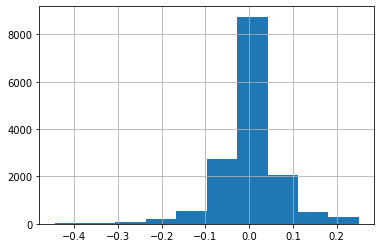

In [41]:
y_train_1_1.hist()

In [43]:
# Compute baseline prediction using mean

mean, median = y_train_1_1.agg(['mean', 'median'])

baseline = np.array([mean]*y_train_1_1.size)
baseline[:5], len(baseline)

(array([0.00195396, 0.00195396, 0.00195396, 0.00195396, 0.00195396]), 15165)

In [45]:
# Compute baseline sse

baseline_residual = y_train_1_1 - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

72.8356969472252

In [47]:
# Compute baseline mse

baseline_mse = baseline_sse/y_train_1_1.size
baseline_mse

0.0048028814340405675

In [50]:
# Compute baseline rmse

baseline_rmse = mean_squared_error(y_train_1_1, baseline)**1/2
baseline_rmse

0.0024014407170202838

In [51]:
def plot_residuals(actual, predicted, feature):
    """
    Returns the scatterplot of actural y in horizontal axis and residuals in vertical axis
    Parameters: actural y(df.se), predicted y(df.se), feature(str)
    Prerequisite: call function evaluate_slr
    """
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title(f'Actual vs Residual on {feature}')
    return plt.gca()

In [61]:
def plot_residuals_percentage(actual, predicted, feature):
    """
    Returns the scatterplot of actural y in horizontal axis and residuals in vertical axis
    Parameters: actural y(df.se), predicted y(df.se), feature(str)
    Prerequisite: call function evaluate_slr
    """
    residuals = actual - predicted
    residuals_percentage = residuals/actual
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals_percentage)
    plt.ylabel('residual ($y - \hat{y}$)%')
    plt.xlabel('actual value ($y$)')
    plt.title(f'Actual vs Residual% on {feature}')
    return plt.gca()

### Test 3 different algorithms for f_features and rfe_features
- LinearRegression
- LassoLars
- Poly(2nd degree)

In [53]:
# Create X_train_scaled for f_features and rfe_features

X_train_scaled_1_1_f = X_train_scaled_1_1[f_features_1_1]
X_train_scaled_1_1_rfe = X_train_scaled_1_1[rfe_features_1_1]

In [54]:
# Confirm f_features are selected correctly

X_train_scaled_1_1_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15165 entries, 17052781 to 14530930
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   error_type                           15165 non-null  int64  
 1   fips_Orange                          15165 non-null  int64  
 2   bathroomcnt_scaled                   15165 non-null  float64
 3   bedroomcnt_scaled                    15165 non-null  float64
 4   calculatedfinishedsquarefeet_scaled  15165 non-null  float64
 5   finishedsquarefeet12_scaled          15165 non-null  float64
 6   fullbathcnt_scaled                   15165 non-null  float64
 7   roomcnt_scaled                       15165 non-null  float64
 8   yearbuilt_scaled                     15165 non-null  float64
 9   landtaxvaluedollarcnt_scaled         15165 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.3 MB


In [55]:
# Confirm rfe_features are selected correctly

X_train_scaled_1_1_rfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15165 entries, 17052781 to 14530930
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   error_type                           15165 non-null  int64  
 1   bathroomcnt_scaled                   15165 non-null  float64
 2   buildingqualitytypeid_scaled         15165 non-null  float64
 3   calculatedfinishedsquarefeet_scaled  15165 non-null  float64
 4   finishedsquarefeet12_scaled          15165 non-null  float64
 5   fullbathcnt_scaled                   15165 non-null  float64
 6   structuretaxvaluedollarcnt_scaled    15165 non-null  float64
 7   taxvaluedollarcnt_scaled             15165 non-null  float64
 8   landtaxvaluedollarcnt_scaled         15165 non-null  float64
 9   logtaxvaluedollarcnt_scaled          15165 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.3 MB


In [57]:
# Confirm y_train

y_train_1_1[:5]

parcelid
17052781    0.045179
11162056    0.000996
14033552   -0.012577
14253441   -0.065676
14142789    0.010418
Name: logerror, dtype: float64

### LinearRegression

In [58]:
# Create lm object

lm = LinearRegression(normalize=True)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [60]:
# Fit train dataset with f_features, predict and calculate the lm_rmse

lm_f = lm.fit(X_train_scaled_1_1_f, y_train_1_1)
lm_pred_f = lm_f.predict(X_train_scaled_1_1_f)
lm_rmse_f = mean_squared_error(y_train_1_1, lm_pred_f)**1/2

lm_rmse_f

0.0013638278316285659

In [64]:
# Fit train dataset with rfe_features, predict and calculate the lm_rmse

lm_rfe = lm.fit(X_train_scaled_1_1_rfe, y_train_1_1)
lm_pred_rfe = lm_rfe.predict(X_train_scaled_1_1_rfe)
lm_rmse_rfe = mean_squared_error(y_train_1_1, lm_pred_rfe)**1/2

lm_rmse_rfe

0.001362398014085791

### LassoLars()

In [65]:
# Create lars object (alpha=0.1)

lars = LassoLars(alpha=0.1)
lars

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [66]:
# Fit train dataset with f_features, predict and calculate the rmse

lars_f = lars.fit(X_train_scaled_1_1_f, y_train_1_1)
lars_pred_f = lars_f.predict(X_train_scaled_1_1_f)
lars_rmse_f = mean_squared_error(y_train_1_1, lars_pred_f)**1/2

lars_rmse_f

0.0024014407170202838

In [67]:
# Fit train dataset with rfe_features, predict and calculate the lm_rmse

lars_rfe = lars.fit(X_train_scaled_1_1_rfe, y_train_1_1)
lars_pred_rfe = lars_rfe.predict(X_train_scaled_1_1_rfe)
lars_rmse_rfe = mean_squared_error(y_train_1_1, lars_pred_rfe)**1/2

lars_rmse_rfe

0.0024014407170202838

### Poly (2nd Degree)

In [122]:
# Transform X_train_scaled_f and _rfe to squared.

pf2 = PolynomialFeatures(degree=2)
X_train_scaled_squared_f = pf2.fit_transform(X_train_scaled_1_1_f)
X_train_scaled_squared_rfe = pf2.fit_transform(X_train_scaled_1_1_rfe)

In [123]:
# Create lm_squared object

lm_squared2 = LinearRegression()

In [124]:
# Fit X_train_scaled_squared_f, predict and compute the rmse

lm_squared_f = lm_squared2.fit(X_train_scaled_squared_f, y_train_1_1)
lm_squared_pred_f = lm_squared_f.predict(X_train_scaled_squared_f)

lm_squared_rmse_f = mean_squared_error(y_train_1_1, lm_squared_pred_f)**1/2
lm_squared_rmse_f

0.001286513535963518

In [125]:
# Fit X_train_scaled_squared_rfe, predict and compute the rmse

lm_squared_rfe = lm_squared2.fit(X_train_scaled_squared_rfe, y_train_1_1)
lm_squared_pred_rfe = lm_squared_rfe.predict(X_train_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_train_1_1, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

0.0013232589698699358

In [126]:
# Summarize the RMSE of all 6 models

rmse_values = [baseline_rmse,
               lm_rmse_f, lm_rmse_rfe, 
               lars_rmse_f, lars_rmse_rfe, 
               lm_squared_rmse_f, lm_squared_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_rmse_f', 'lm_rmse_rfe',
              'lars_rmse_f', 'lars_rmse_rfe',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe']

rmse = pd.DataFrame(rmse_values, index=rmse_index, columns=['RMSE'])
rmse.sort_values(by='RMSE')

,RMSE
lm_squared_rmse_f,0.001287
lm_squared_rmse_rfe,0.001323
lm_rmse_rfe,0.001362
lm_rmse_f,0.001364
baseline_rmse,0.002401
lars_rmse_f,0.002401
lars_rmse_rfe,0.002401


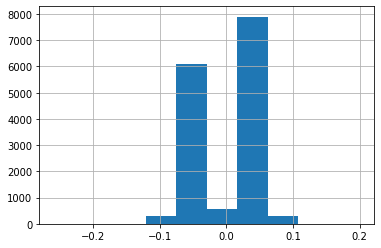

In [82]:
pd.Series(lm_squared_pred_f).hist()

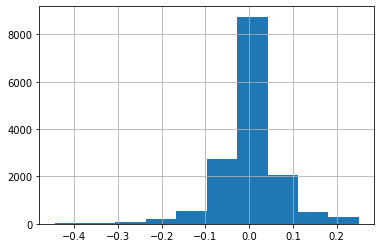

In [84]:
y_train_1_1.hist()

### Validate top 3 models
### Poly (2nd) with both f_ and rfe_features

In [127]:
# Confirm scaled validate dataset of X for group 1 cluster1

X_validate_scaled_1_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6386 entries, 14231041 to 12122780
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   error_type                           6386 non-null   int64  
 1   fips_Orange                          6386 non-null   int64  
 2   fips_Ventura                         6386 non-null   int64  
 3   bathroomcnt_scaled                   6386 non-null   float64
 4   bedroomcnt_scaled                    6386 non-null   float64
 5   buildingqualitytypeid_scaled         6386 non-null   float64
 6   calculatedfinishedsquarefeet_scaled  6386 non-null   float64
 7   finishedsquarefeet12_scaled          6386 non-null   float64
 8   fullbathcnt_scaled                   6386 non-null   float64
 9   latitude_scaled                      6386 non-null   float64
 10  longitude_scaled                     6386 non-null   float64
 11  lotsizesquarefeet_s

In [128]:
# Confirm scaled validate dataset of y for group 1 cluster1

y_validate_1_1[:5]

parcelid
14231041    0.003414
12451996    0.014366
11103322    0.005269
13073542    0.055054
14465516    0.132418
Name: logerror, dtype: float64

In [129]:
# Create X_validate_scaled for f_features and rfe_features

X_validate_scaled_1_1_f = X_validate_scaled_1_1[f_features_1_1]
X_validate_scaled_1_1_rfe = X_validate_scaled_1_1[rfe_features_1_1]

In [130]:
# Transform X_validate_scaled_f and _rfe to squared.

X_validate_scaled_squared_f = pf2.transform(X_validate_scaled_1_1_f)
X_validate_scaled_squared_rfe = pf2.transform(X_validate_scaled_1_1_rfe)

In [131]:
# Fit X_validate_scaled_squared_f, predict and compute the rmse

lm_squared_pred_f = lm_squared_f.predict(X_validate_scaled_squared_f)

lm_squared_rmse_f = mean_squared_error(y_validate_1_1, lm_squared_pred_f)**1/2
lm_squared_rmse_f

5.553328183871766e+20

In [132]:
# Fit X_validate_scaled_squared_rfe, predict and compute the rmse

lm_squared_pred_rfe = lm_squared_rfe.predict(X_validate_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_validate_1_1, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

2.359372893449051e+17

### LinearRegression with rfe features

In [133]:
lm_pred = lm.predict(X_validate_scaled_1_1_rfe)
lm_rmse = mean_squared_error(y_validate_1_1, lm_pred)**1/2

lm_rmse

0.0013295100424344794

### Test for the best model: LinearRegression with rfe features

In [134]:
# Create X_train_scaled for rfe_features

X_test_scaled_1_1_rfe = X_test_scaled_1_1[rfe_features_1_1]

In [135]:
lm_pred = lm.predict(X_test_scaled_1_1_rfe)
lm_rmse = mean_squared_error(y_test_1_1, lm_pred)**1/2

lm_rmse

0.0013398546021102945